# Upload NMF inputs and outputs to database
Charley Wu, November 2020

In [1]:
import pymongo
import os
import bson
import json
import glob
import pickle
import gridfs
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
from os.path import join as opj
from tqdm import notebook
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
import sys

In [2]:
sys.path.append('../3_technology')
import ohol_objects as obj

ModuleNotFoundError: No module named 'ohol_objects'

Connect to database:

In [3]:
keyfile = 'credentials.key'
creds = open(keyfile, "r").read().splitlines()
myclient = pymongo.MongoClient('134.76.24.75', username=creds[0], password=creds[1], authSource='ohol') 
db = myclient.ohol

print(db)
print(db.list_collection_names())

Database(MongoClient(host=['134.76.24.75:27017'], document_class=dict, tz_aware=False, connect=True, authsource='ohol'), 'ohol')
['old_svd', 'old_jobmatrix', 'objects', 'transitions', 'categories']


## Jobmatrix

List job files:

In [4]:
job_col = db.jobmatrix #collection

n = job_col.estimated_document_count() #number of avatars
m = len(job_col.find_one()['items']) #number of items
jobMatrix = np.empty([n,m])
avatarId = np.empty([n])

i = 0 #counter
for doc in job_col.find(): #iterate and build the job matrix
    jobMatrix[i,] = doc['items']
    avatarId[i] = doc['avatar']
    i+=1

itemDict = db.svd.find_one({"items":{'$exists': True}})['items'] # Create item dictionary

TypeError: 'NoneType' object is not subscriptable

In [5]:
jobMatrix.shape

(4072, 2991)

## Preprocessing

### clean participants based on age/cause of death

In [9]:
playerDF = pd.DataFrame(db.lifelogs.find({"avatar":{"$in":list(avatarId)}})) #query for avatar ids
#set up some filters
playerDF = playerDF[(playerDF['age']>=14) & (playerDF['cause_of_death'] != 'disconnect')] #remove people
    

In [10]:
#create new cleaned job matrix
jobMatrix = np.array([q['items'] for q in db.jobmatrix.find({'avatar': {"$in": list(playerDF['avatar'])}})]) 
avatarId = [q['avatar'] for q in db.jobmatrix.find({'avatar': {"$in": list(playerDF['avatar'])}})]


### Look at number of interactions

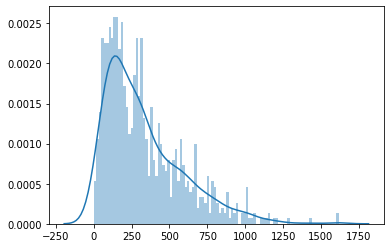

In [11]:
sns.distplot(jobMatrix.sum(axis = 1), bins = 100) #histrogram of item iteractions

### Clean empty columns 

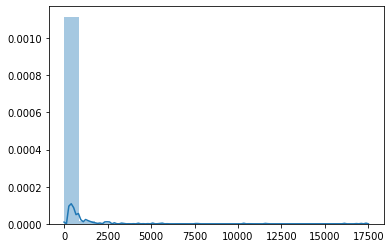

In [12]:
sns.distplot(jobMatrix.sum(axis = 0), bins = 20) #histrogram of items and how many different players interact with them

In [13]:
trimmed_idx = [itemDict[idx] for idx, include in enumerate(jobMatrix.sum(axis = 0)>0) if include] #create trimmed indicies
jobMatrixCleaned = jobMatrix[:,jobMatrix.sum(axis = 0)>0] #remove all columns that no users have interacted with


In [14]:
jobMatrixCleaned.shape #new cleaned job matrix dimensions
#TODO: Build a dictionary to relate each row to each avatar id

(934, 1308)

### TF-IDF normalization

In [15]:
#Term frequency: let's use augmented frequency, which prevents a bias towards longer documents (i.e., players who have many item interactions)
def tf(avatarVec):
    return(0.5 + ((0.5* avatarVec) / max(avatarVec)))

#inverse document frequency:
def idf(itemVec):
    return(np.log(sum(itemVec)/len(itemVec[itemVec>0])))

In [16]:
#compute tf and idf mats
tfMat = np.ones(jobMatrixCleaned.shape)
for row in range(jobMatrixCleaned.shape[0]):
    tfMat[row,:] = tf(jobMatrixCleaned[row,:]) 
idfMat = np.ones(jobMatrixCleaned.shape)
for col in range(jobMatrixCleaned.shape[1]):
    idfMat[:,col] = idf(jobMatrixCleaned[:,col]) 
tfIdfMat = tfMat * idfMat

In [17]:
tfidfJobMatrix = tfIdfMat * jobMatrixCleaned #now compute tfidf

In [18]:
jobMatrixCleaned.shape

(934, 1308)

In [20]:
#Normalized rows
row_sums = tfidfJobMatrix.sum(axis=1)
tfidfJobMatrixNormalized = tfidfJobMatrix / row_sums[:, np.newaxis]
tfidfJobMatrixNormalized = np.nan_to_num(tfidfJobMatrixNormalized)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


# Non-negative matrix factorization

In [22]:
model = NMF(n_components=20, init='random', random_state=0)
W = model.fit_transform(tfidfJobMatrixNormalized)
H = model.components_
#TODO: Save W and H matrices somewhere

## Interpreting the components

Text(0.5, 15.0, 'Avatar')

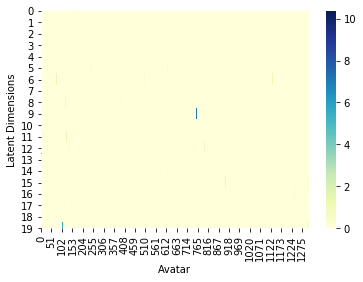

In [29]:
#How well can we allocate players to different latent dimensions?
ax = sns.heatmap(H,  cmap="YlGnBu") #x-axis are unique items and y-axis are the loadings
ax.set_ylabel('Latent Dimensions')
ax.set_xlabel('Avatar')

(array([5., 1., 6., 1., 1., 3., 1., 0., 1., 1.]),
 array([ 1.52385878,  3.24715147,  4.97044416,  6.69373685,  8.41702954,
        10.14032224, 11.86361493, 13.58690762, 15.31020031, 17.03349301,
        18.7567857 ]),
 <a list of 10 Patch objects>)

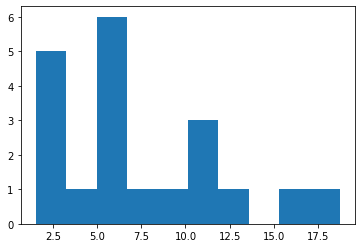

In [30]:
#What is the distribution of total loadings across items?
plt.hist(H.sum(axis = 1))

In [26]:
#Which items most strongly defined each component?
for C in range(H.shape[0]):
    comp = H[C,] #component
    items = comp.argsort()[-5:][::-1] #sort by weight; select the top 5 items
    print(C)
    for item in items:
        try:
            objname = obj.obj_name(int(trimmed_idx[item])) #relate to item id using the trimmed_idx, and then look up
            weight = str(comp[item])
            print(' : '.join([objname, weight]))
        except:
            print(' : '.join([str(int(trimmed_idx[item])), str(comp[item])]))
    print('')


0
Wild Gooseberry Bush : 4.099640458277407
Empty Wild Gooseberry Bush : 0.20932237375522764
Gooseberry : 0.11308565073194976
Milkweed Stalk : 0.05053722707636989
Stone : 0.042367415090864495

1
Clay Bowl - empty : 3.0651711239451798
Stack of Clay Bowls : 0.19635705486215446
Bowl of Dry Beans : 0.10737406325248046
Deep Tilled Row - groundOnly : 0.10448241771730876
Shallow Well - +famUse100 +tapoutTrigger &40 &40 &160 &160 : 0.08809882860788246

2
Domestic Gooseberry Bush : 10.370015207602247
Empty Domestic Gooseberry Bush : 0.47907952187633424
Gooseberry : 0.26321229507845406
Stack of Firewood : 0.11214757410946706
Steel Axe - +toolChopping : 0.10994885009695682

3
Basket : 4.098136763377464
Dead Rabbit : 0.04975630992809233
Bone Pile - origGrave : 0.04963520614455063
Dug Wild Carrot : 0.04886627576124149
Clay : 0.04030393659379515

4
Bowl of Gooseberries - +yum31 : 4.810439347569614
Bowl of Gooseberries and Carrot : 0.10907277609662357
Gooseberry : 0.05319797532318836
Flat Rock with Ra

## Interpreting avatar embeddings

Text(33.0, 0.5, 'Avatar')

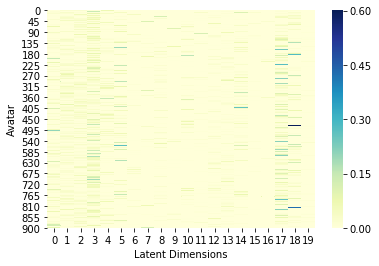

In [31]:
ax = sns.heatmap(W,  cmap="YlGnBu") #players are loading very heavily onto dims 2 and 16. We may need better preprocessing
ax.set_xlabel('Latent Dimensions')
ax.set_ylabel('Avatar')

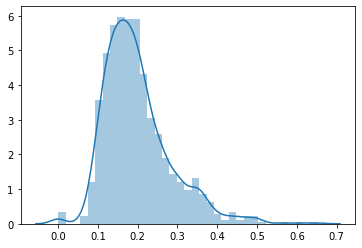

In [34]:
#Sum of loadings 
sns.distplot(W.sum(axis = 1)) #The magnitude of the embedding vector for each player tells us how confidently we are able to assign that player to the latent space. 

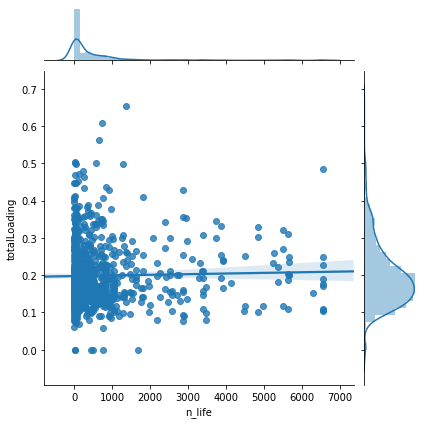

In [88]:
#Can we relate the magnitude of the embedding to other characteristics?
playerDF['totalLoading'] = W.sum(axis = 1)
sns.jointplot(data=playerDF, x='n_life', y = 'totalLoading', kind = 'reg') #alternative can look at 'age', 'gen', etc...
plt.show()

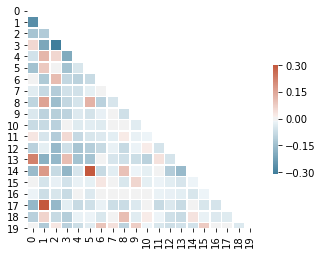

In [89]:
#How correlated are the latent embedding dimensions?
corr = pd.DataFrame(W).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))


# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [35]:
#PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(W)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


In [36]:
print(pca.explained_variance_) #not very much

[0.00360796 0.00261188]


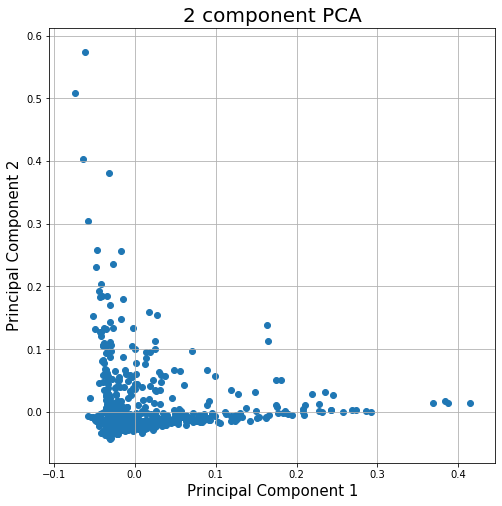

In [37]:
#Job space embeddings
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
ax.scatter(principalDf['principal component 1'],principalDf['principal component 2'])
ax.grid()

## Compare with other player data

In [123]:
#add latent dimensions
jobDF = playerDF
for i in range(20):
    jobDF['Dim'+str(i)] = W[:,i]

In [163]:
#Add the PCA reduced components
jobDF['PCA1'] = principalDf['principal component 1']
jobDF['PCA2'] = principalDf['principal component 2']

In [184]:
#Which was the strongest dimensions for each player?
jobDF['maxDim'] = np.argmax(W, axis = 1)

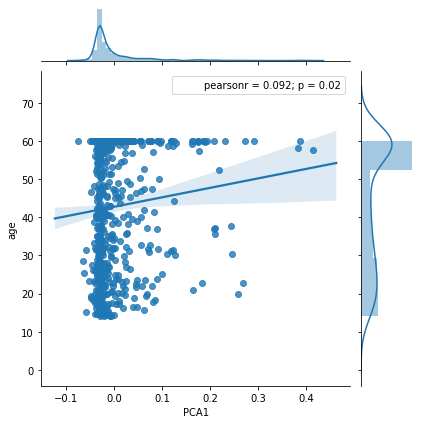

In [167]:
p = sns.jointplot(data=jobDF, x='PCA1', y = 'age', kind = 'reg') #alternative can look at 'age', 'gen', etc...
p.annotate(stats.pearsonr)
plt.show()

In [211]:
jobDF.family.value_counts()

time-1573896495_eve-2276927_name-LISSADE    311
time-1573907431_eve-2277342_name-FINCH      165
time-1573909483_eve-2277421_name-ISPAS      140
time-1573934909_eve-2279109_name-ALICE       84
time-1573933442_eve-2278996_name-MORT        60
time-1573928065_eve-2278562_name-CALIN       54
time-1573965243_eve-2280850_name-ETERNO      42
time-1573896134_eve-2276919_name-SARINA      33
time-1573896101_eve-2276917_name-BADA        14
time-1573895755_eve-2276905_name-ZABICKI      9
time-1573914221_eve-2277632_name-WILD         7
time-1573918105_eve-2277860_name-RUTH         5
time-1573905001_eve-2277238_name-NORTH        3
time-1573913113_eve-2277579_name-IN           2
time-1573964144_eve-2280799_name-OISTEN       1
time-1573923963_eve-2278242_name-DESTINO      1
time-1573923283_eve-2278172_name-POPS         1
time-1573922618_eve-2278121_name-ZAZA         1
time-1573895904_eve-2276911_name-ROHRER       1
Name: family, dtype: int64

In [152]:
#Which families live the longest?
lifespanDF = jobDF.groupby('family', as_index=False).agg({'age': 'mean'}).sort_values('age') #compute mean age and sort
lifespanDF

,family,age
11,time-1573922618_eve-2278121_name-ZAZA,18.940000
8,time-1573913113_eve-2277579_name-IN,20.150000
5,time-1573905001_eve-2277238_name-NORTH,22.736667
13,time-1573923963_eve-2278242_name-DESTINO,22.780000
1,time-1573895904_eve-2276911_name-ROHRER,22.820000
12,time-1573923283_eve-2278172_name-POPS,22.990000
17,time-1573964144_eve-2280799_name-OISTEN,23.080000
10,time-1573918105_eve-2277860_name-RUTH,28.598000
9,time-1573914221_eve-2277632_name-WILD,31.788571
0,time-1573895755_eve-2276905_name-ZABICKI,31.823333


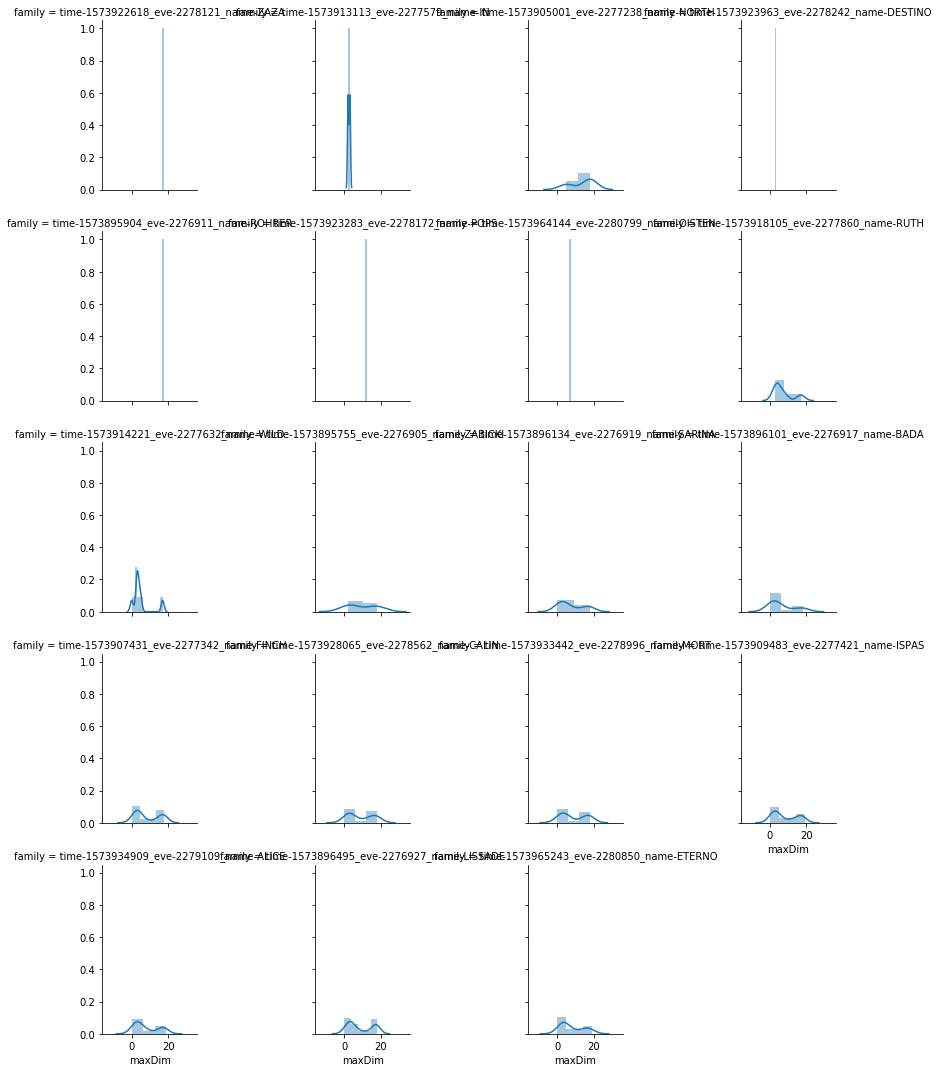

In [203]:
g = sns.FacetGrid(jobDF, col='family', col_wrap=4, col_order=lifespanDF['family'])
g.map(sns.distplot, "maxDim")
plt.show()

(array([3., 2., 4., 6., 1., 3., 1., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0.,
        0., 6., 3.]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ,
         9.9, 10.8, 11.7, 12.6, 13.5, 14.4, 15.3, 16.2, 17.1, 18. ]),
 <a list of 20 Patch objects>)

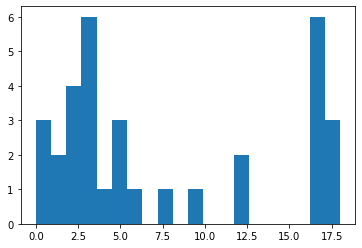

In [208]:
#Plot only the most successful family
plt.hist(jobDF[jobDF['family']==list(lifespanDF['family'])[18]]['maxDim'], bins = 20)

In [209]:
jobDF[jobDF['family']==list(lifespanDF['family'])[18]].maxDim.value_counts()

17    6
3     6
2     4
18    3
5     3
0     3
12    2
1     2
9     1
8     1
6     1
4     1
Name: maxDim, dtype: int64

(array([3., 2., 4., 6., 1., 3., 1., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0.,
        0., 6., 3.]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ,
         9.9, 10.8, 11.7, 12.6, 13.5, 14.4, 15.3, 16.2, 17.1, 18. ]),
 <a list of 20 Patch objects>)

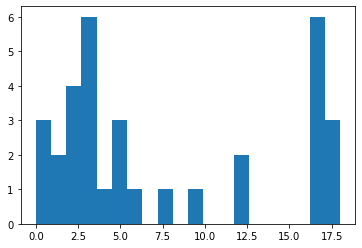

In [212]:
#Now plot a low life expetancy family
plt.hist(jobDF[jobDF['family']==list(lifespanDF['family'])[10]]['maxDim'], bins = 20)

In [214]:
jobDF[jobDF['family']==list(lifespanDF['family'])[10]].maxDim.value_counts()

17    6
3     6
2     4
18    3
5     3
0     3
12    2
1     2
9     1
8     1
6     1
4     1
Name: maxDim, dtype: int64

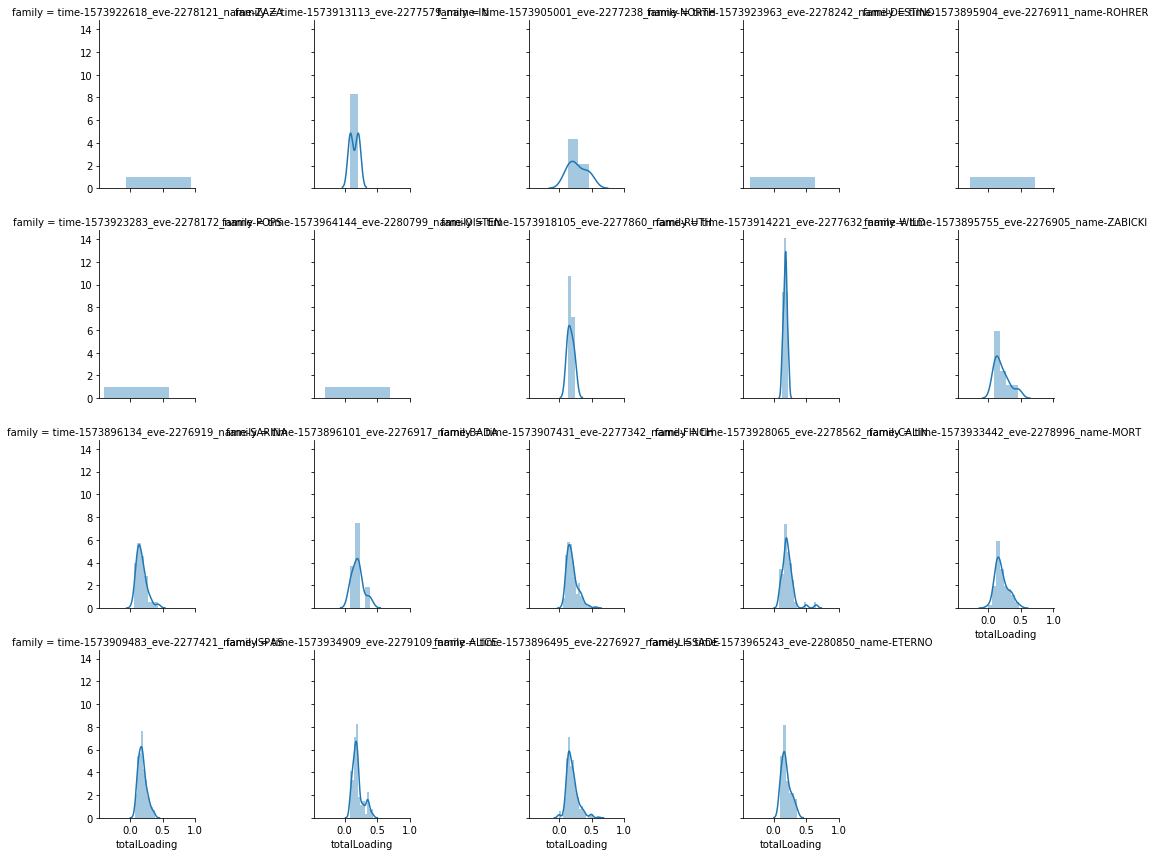

In [172]:
g = sns.FacetGrid(jobDF, col='family', col_wrap=5, col_order=lifespanDF['family'])
g.map(sns.distplot, "totalLoading")
plt.show()